In [1]:
import numpy as np
import os
import shutil
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from matplotlib import pyplot as plt

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as k
import os

2022-07-13 22:59:44.262061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 22:59:44.262089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### DESCARGAMOS Y DESCOMPRIMIMOS DATASET DE COCHES

In [4]:
!wget https://github.com/vincent1bt/tesla-cars-dataset/archive/master.zip
!unzip -qq master.zip
!mkdir -p validation_images/tesla_model_3 && mkdir validation_images/tesla_model_s && mkdir validation_images/tesla_model_x

--2022-07-13 23:00:04--  https://github.com/vincent1bt/tesla-cars-dataset/archive/master.zip
Resolviendo github.com (github.com)... 140.82.121.3
Conectando con github.com (github.com)[140.82.121.3]:443... conectado.
Petición HTTP enviada, esperando respuesta... 302 Found
Localización: https://codeload.github.com/vincent1bt/tesla-cars-dataset/zip/refs/heads/master [siguiendo]
--2022-07-13 23:00:04--  https://codeload.github.com/vincent1bt/tesla-cars-dataset/zip/refs/heads/master
Resolviendo codeload.github.com (codeload.github.com)... 140.82.121.10
Conectando con codeload.github.com (codeload.github.com)[140.82.121.10]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: no especificado [application/zip]
Grabando a: «master.zip.1»

master.zip.1            [           <=>      ] 188,48M  5,08MB/s    en 41s     

2022-07-13 23:00:46 (4,61 MB/s) - «master.zip.1» guardado [197632877]

[master.zip]
  End-of-central-directory signature not found.  Either this file 

### SEPARAMOS DATASET DE ENTRENAMIENTO Y DE VALIDACION

In [5]:
validation_set_size = 30
def move_images(from_path, to_path):
  files = os.listdir(from_path)
  folder_size = len(files)
  first_index = folder_size - validation_set_size
  files_to_move = files[first_index:]
  
  for file_name in files_to_move:
    source_file_name = from_path + file_name
    destination_file_name = to_path + file_name
    shutil.move(source_file_name, destination_file_name)
    
move_images("./tesla-cars-dataset-master/tesla-model-3/", "./validation_images/tesla_model_3/")
move_images("./tesla-cars-dataset-master/tesla-model-s/", "./validation_images/tesla_model_s/")
move_images("./tesla-cars-dataset-master/tesla-model-x/", "./validation_images/tesla_model_x/")  

#Cambiamos el nombre de la carpeta para ENTRENAMIENTO
!mv tesla-cars-dataset-master training_images
!mv training_images/tesla-model-3 training_images/tesla_model_3
!mv training_images/tesla-model-s training_images/tesla_model_s
!mv training_images/tesla-model-x training_images/tesla_model_x

!ls training_images

FileNotFoundError: [Errno 2] No such file or directory: './tesla-cars-dataset-master/tesla-model-3/'

In [6]:
img_height = 256
img_width = 256

def load_images(paths):
  X = []
  y = []
  
  for path in paths:
    images_paths = os.listdir(path)
    
    for image_path in images_paths:
      complete_path = path + image_path
      image = load_img(complete_path, target_size=(img_height, img_width))
      image_array = img_to_array(image)
      X.append(image_array)
      label = paths.index(path)
      y.append(label)
  
  return X, y

In [7]:
training_paths = ["content/training_images/tesla_model_3/", "content/training_images/tesla_model_s/", "content/training_images/tesla_model_x/"]
validation_paths = ["content/validation_images/tesla_model_3/", "content/validation_images/tesla_model_s/", "content/validation_images/tesla_model_x/"]

X_train, y_train = load_images(training_paths)
X_val, y_val = load_images(validation_paths)

X_train = np.array(X_train)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_val = np.array(y_val)

X_train.shape, X_val.shape

/home/nbellorin/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


((356, 256, 256, 3), (90, 256, 256, 3))

In [8]:
y_train.shape, y_val.shape

((356,), (90,))

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train.shape, y_val.shape

((356, 3), (90, 3))

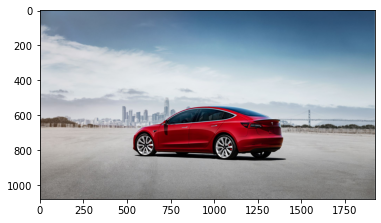

In [10]:
datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1. / 255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

img = load_img("content/training_images/tesla_model_3/1-2.jpg")

plt.imshow(img)

### DATAGEN PARA DATA AUMENGTATION

In [11]:
! rm -rf preview
!mkdir preview
img = load_img("content/training_images/tesla_model_3/1-2.jpg", target_size=(256, 256))
img = img_to_array(img)
img = img.reshape((1,) + img.shape)

i = 0
for batch in datagen.flow(img, batch_size=1,
  save_to_dir='preview', save_prefix='car', save_format='jpeg'):
    i += 1
    if i > 20:
        break

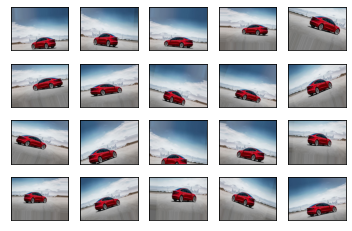

In [12]:
#CARGAMOS IMAGENES DE PRUEBA
def load_preview_images():
  path = "./content/preview/"
  X = []
  
  images_paths = os.listdir(path)
    
  for image_path in images_paths:
    complete_path = path + image_path
    image = load_img(complete_path)
    X.append(image)
    
  return X

X_preview = load_preview_images()

# PINTAMOS LAS IMAGENES
def plot_images(images):    
  fig, axes = plt.subplots(4, 5)
  plt.rcParams["figure.figsize"] = (20, 15)
  
  for i, ax in enumerate(axes.flat):
      ax.imshow(images[i])
      
      ax.set_xticks([])
      ax.set_yticks([])
    
  plt.show()
  
plot_images(X_preview)

In [13]:
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1. / 255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

valid_generator = ImageDataGenerator(rescale = 1. / 255)
input_shape=(256, 256, 3)
kernel_size = 5

In [14]:
def create_model(X_train, X_val, y_train, y_val, learning_rate, epochs, batch_size, callbacks):
  model = Sequential()

  #Primera capa
  model.add(Conv2D(64, 
        kernel_size=(kernel_size, kernel_size), padding="valid",
        strides=1, input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  #Segunda capa
  model.add(Conv2D(64, 
        kernel_size=(kernel_size, kernel_size), padding="valid", strides=1))
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  #Tercera capa

  model.add(Conv2D(64, 
        kernel_size=(kernel_size, kernel_size), padding="valid",
        strides=1,))
  model.add(Activation('relu'))
  model.add(MaxPooling2D())
  
  #Convertir los datos

  model.add(Flatten())

  #Cuarta capa
  model.add(Dense(500))
  model.add(Activation('relu'))

  #Clasificación 
  model.add(Dense(3))
  model.add(Activation('softmax'))
  
  AdamOptimizer = optimizers.Adam(lr=learning_rate)
  
  model.compile(optimizer=AdamOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
  model_trained = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=batch_size, shuffle = True), steps_per_epoch=len(X_train) // batch_size, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=valid_generator.flow(X_val, y_val, shuffle = True), validation_steps=len(X_val) // batch_size)
  
  return model_trained, model

In [15]:
epochs = 10
batch_size = 32
learning_rate = 0.0003


#callbacks = [ModelCheckpoint(filepath='weights.{epoch:02d}-val_acc:{val_acc:.2f}.h5', monitor='val_acc', save_best_only=True, verbose=1)]
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),


In [16]:
model_trained, model = create_model(X_train, X_val, y_train, y_val, learning_rate, epochs, batch_size, callbacks)

2022-07-13 23:01:44.717620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 23:01:44.717650: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 23:01:44.717664: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isyc): /proc/driver/nvidia/version does not exist
2022-07-13 23:01:44.717911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nbellorin/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr`

Epoch 1/10
11/11 [==============================] - 33s 3s/step - loss: 1.1982 - accuracy: 0.3210 - val_loss: 1.1265 - val_accuracy: 0.3281
Epoch 2/10
11/11 [==============================] - 35s 3s/step - loss: 1.1092 - accuracy: 0.3409 - val_loss: 1.0988 - val_accuracy: 0.3125
Epoch 3/10
11/11 [==============================] - 33s 3s/step - loss: 1.1018 - accuracy: 0.3025 - val_loss: 1.0968 - val_accuracy: 0.3281
Epoch 4/10
11/11 [==============================] - 33s 3s/step - loss: 1.0979 - accuracy: 0.3364 - val_loss: 1.0987 - val_accuracy: 0.3125
Epoch 5/10
11/11 [==============================] - 33s 3s/step - loss: 1.1013 - accuracy: 0.3364 - val_loss: 1.0973 - val_accuracy: 0.3438
Epoch 6/10
11/11 [==============================] - 35s 3s/step - loss: 1.0960 - accuracy: 0.3333 - val_loss: 1.0838 - val_accuracy: 0.3438
Epoch 7/10
11/11 [==============================] - 34s 3s/step - loss: 1.0866 - accuracy: 0.3148 - val_loss: 1.0476 - val_accuracy: 0.3750
Epoch 8/10
11/11 [==

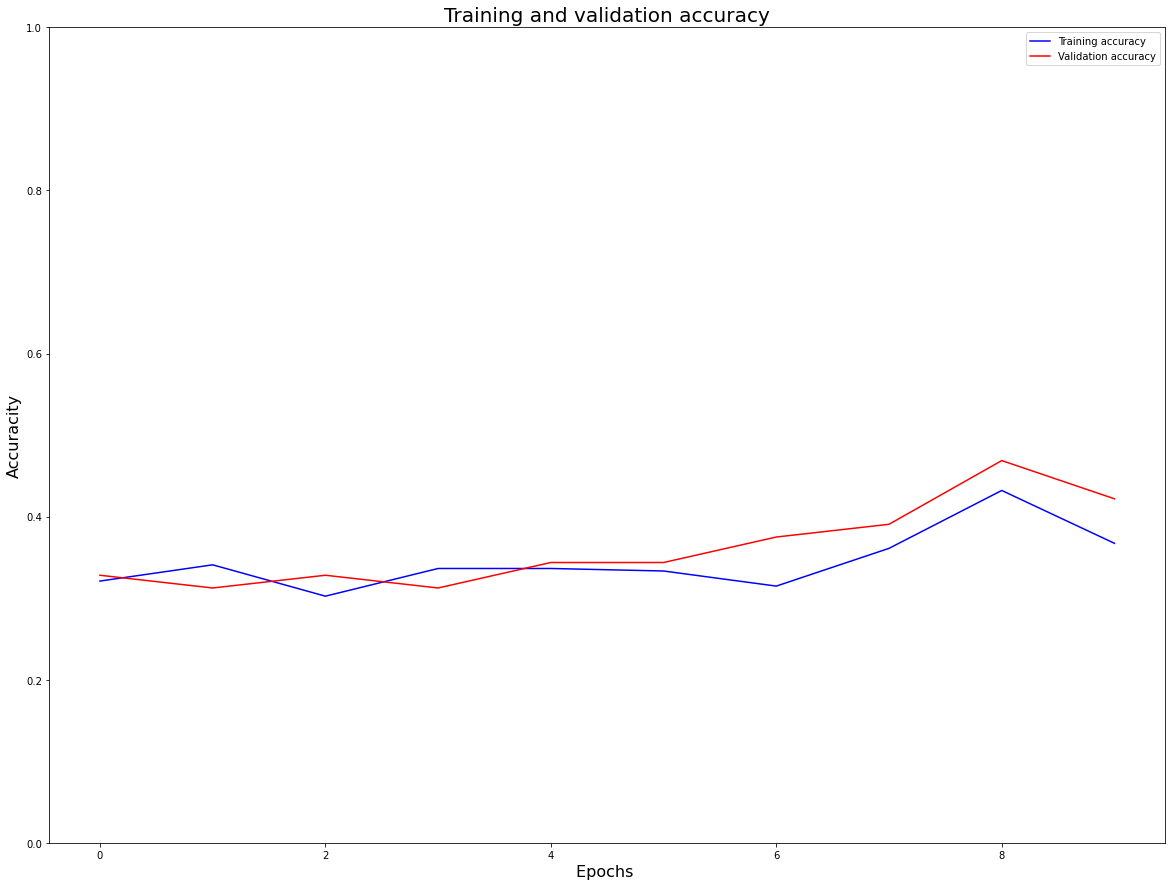

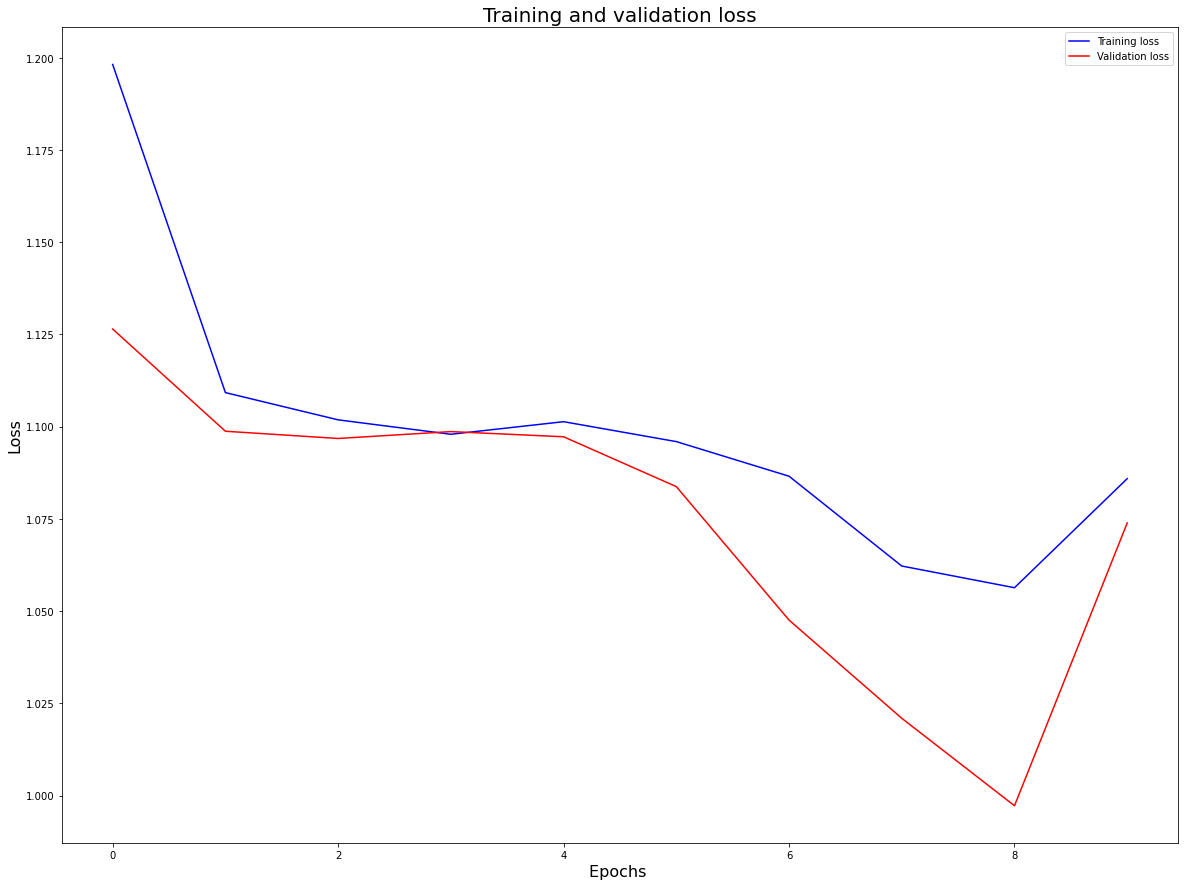

Validation accuracy: 42.1875%
Training Accuracy: 36.72839403152466%


In [17]:

def plot_loss_and_accuracy(model_trained):
  accuracy = model_trained.history['accuracy']
  val_accuracy = model_trained.history['val_accuracy']
  loss = model_trained.history['loss']
  val_loss = model_trained.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'b', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
  plt.ylim(ymin=0)
  plt.ylim(ymax=1)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel('Accuracity', fontsize=16)
  plt.title('Training and validation accuracy', fontsize = 20)
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.title('Training and validation loss', fontsize= 20)
  plt.legend()
  plt.show()

plot_loss_and_accuracy(model_trained)
validation_acc = model_trained.history['val_accuracy'][-1] * 100
training_acc = model_trained.history['accuracy'][-1] * 100
print("Validation accuracy: {}%\nTraining Accuracy: {}%".format(validation_acc, training_acc))

In [17]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'